In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [9]:
import argparse
import torch.optim as optim
from torchvision import datasets, transforms

def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(args, model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

# Training settings
parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                    help='input batch size for training (default: 64)')
parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                    help='input batch size for testing (default: 1000)')
parser.add_argument('--epochs', type=int, default=10, metavar='N',
                    help='number of epochs to train (default: 10)')
parser.add_argument('--lr', type=float, default=0.01, metavar='LR',
                    help='learning rate (default: 0.01)')
parser.add_argument('--momentum', type=float, default=0.5, metavar='M',
                    help='SGD momentum (default: 0.5)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='disables CUDA training')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                    help='how many batches to wait before logging training status')

# Train this model with 60 epochs and after process every 300 batches log the train status
args = parser.parse_args(['--epochs', '60', '--log-interval', '300'])

use_cuda = not args.no_cuda and torch.cuda.is_available()

torch.manual_seed(args.seed)

device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=args.batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=args.test_batch_size, shuffle=True, **kwargs)


model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)

for epoch in range(1, args.epochs + 1):
    train(args, model, device, train_loader, optimizer, epoch)
    test(args, model, device, test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.371851
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.748811
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.733573


KeyboardInterrupt: 

In [4]:
# Save the trained model to a file
torch.save(model.state_dict(), 'models/mnist_pytorch.pth')

In [5]:
from torch.autograd import Variable

# Load the trained model from file
trained_model = Net()
trained_model.load_state_dict(torch.load('models/mnist_pytorch.pth'))

# Export the trained model to ONNX
dummy_input = Variable(torch.randn(1, 1, 28, 28)) # one black and white 28 x 28 picture will be the input to the model
torch.onnx.export(trained_model, dummy_input, "models/mnist_onnx.onnx")

In [5]:
import onnx
from onnx_tf.backend import prepare

# Load the ONNX file
model = onnx.load('models/mnist_onnx.onnx')

# Import the ONNX model to Tensorflow
tf_rep = prepare(model)

In [7]:
# Input nodes to the model
print('inputs:', tf_rep.inputs)

# Output nodes from the model
print('outputs:', tf_rep.outputs)

# All nodes in the model
print('tensor_dict:')
print(tf_rep.tensor_dict)


inputs: ['input.1']
outputs: ['20']
tensor_dict:
{}


AttributeError: 'TensorflowRep' object has no attribute 'summary'

[1 6 0 6 0 6 0 0 5 2 7 4 6 2 3 1 0 6 3 9 0 2 9 0 8 0 2 2 7 0 0 0 4 3 9 2 3
 4 0 4 4 4 1 6 9 3 7 1 5 1 1 5 7 0 5 0 3 3 2 3 5 4 3 7]


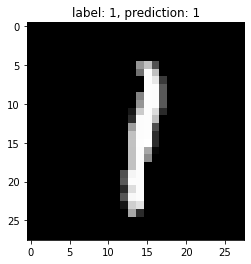

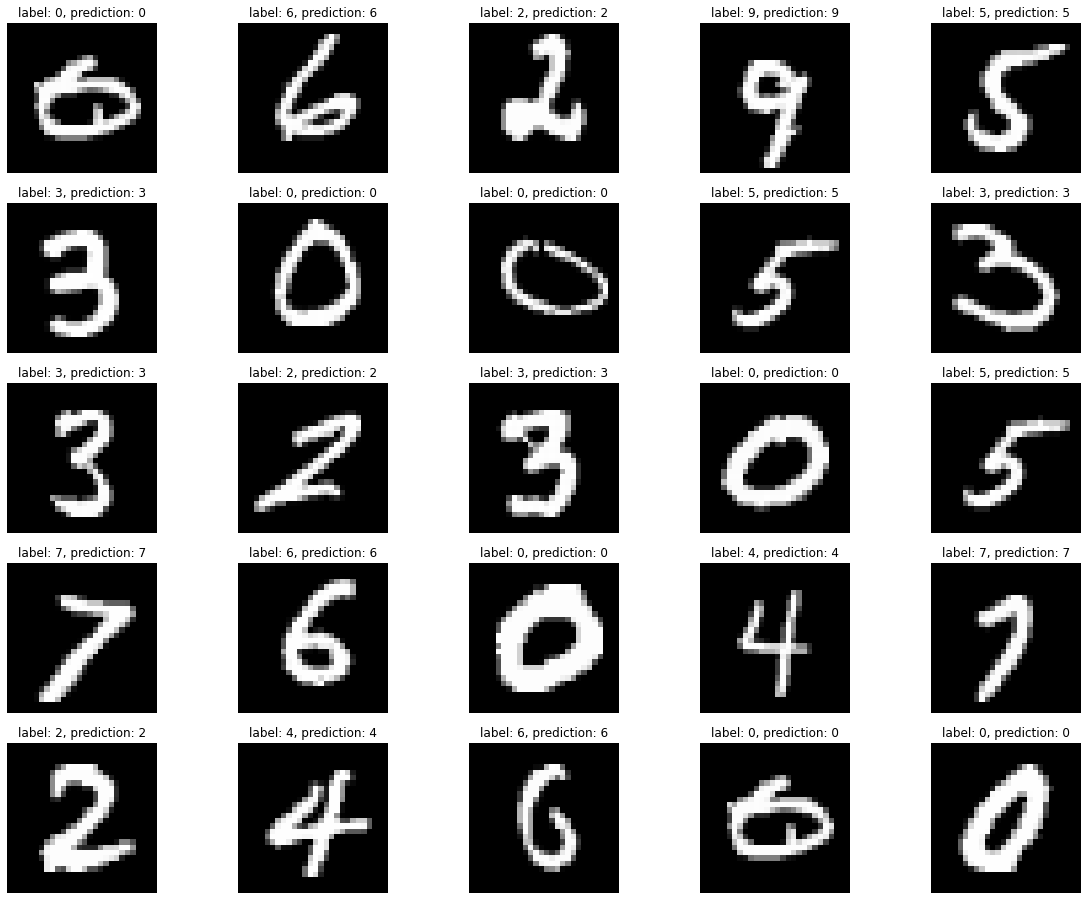

In [25]:
import matplotlib.pyplot as plt
import numpy as np

features, labels = next(iter(train_loader))
output = tf_rep.run(features)
output = np.argmax(output, axis=2)[0]
print(output)
plt.imshow(features[0].reshape((28, 28)), cmap='gray')
plt.title(f'label: {labels[0]}, prediction: {output[0]}')
plt.show()

figure = plt.figure(figsize=(20, 16))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(features), size=(1,)).item()
    figure.add_subplot(rows, cols, i)
    plt.title(f'label: {labels[sample_idx]}, prediction: {output[sample_idx]}')
    plt.axis("off")
    plt.imshow(features[sample_idx].squeeze(), cmap="gray")
plt.show()

In [26]:
tf_rep.export_graph('models/mnist_tf.pb')

INFO:tensorflow:Assets written to: models/mnist_tf.pb\assets


INFO:tensorflow:Assets written to: models/mnist_tf.pb\assets


In [52]:
import tensorflow as tf

tf_model = tf.saved_model.load('models/mnist_tf.pb')
output = tf_model(**{'input.1': features})

print(np.argmax(output['20'], axis=1))

[1 6 0 6 0 6 0 0 5 2 7 4 6 2 3 1 0 6 3 9 0 2 9 0 8 0 2 2 7 0 0 0 4 3 9 2 3
 4 0 4 4 4 1 6 9 3 7 1 5 1 1 5 7 0 5 0 3 3 2 3 5 4 3 7]
